## Optimal Stopping Problems with jump diffusion
This notebook extends the [previous notebook](https://quantecon.github.io/SimpleDifferentialOperators.jl/stable/generated/LCP_simple.html) on simple LCP problems to add a jump diffusive term in the stochastic process for $x$.

## A Univariate Example

Assume the following

* A stochastic process $x$, with [infinitesimal generator](https://en.wikipedia.org/wiki/Infinitesimal_generator_(stochastic_processes)) $\mathcal{L}_x$
  and boundary conditions. 
* Boundary conditions for the $x$ stochastic process (e.g., reflecting barriers at some minimum and maximum.)
* Flow payoffs $u(x)$ discounted at rate $\rho > 0$.
* Stopping payoff $S(x)$ which gives the value of stopping at state $x$.

The control problem is: choose when to stop the process and gain the payoff $S(x)$.  If there are only two regions, then this becomes the choice of a stopping threshold $\hat{x}$.

#### Classical Formulation
First, suppose that $x$ follows the jump diffusion process with the intensity of $\lambda$ and $\alpha$ magnitude. Then, the correspondding infinitesimal generator $\mathcal{L}_x$ is as follows:

$$
\begin{equation}
\mathcal{L}_x =  \mu \partial_x + \frac{\sigma^2}{2}\partial_{xx} + \lambda \mathcal{L}_n (\alpha)
\end{equation}
$$

where $\mathcal{L}_n (\alpha)$ is an operator for the jump process with uniform magnitude of $\alpha$.

In a stationary environment, the Bellman equation within the interior (continuation) region is

$$
\begin{equation}
  \rho v(x) = u(x) + \mathcal{L}_x v(x)
\end{equation}
$$

Define a new operator and rewrite,

$$
\begin{align}
  \mathcal{L} v(x) &= u(x)\label{eq:bellman}\\
  \mathcal{L} &\equiv \rho - \mathcal{L}_x\label{eq:L-op}
\end{align}
$$

Along with boundary conditions from the stochastic process (e.g., a reflecting barrier at an $x_{\min}$ and another at some $x_{\max}$, or a transversality condition.)

In special cases with sufficient monotonicity, there is a single stopping region, defined by a threshold at $\hat{x}$.

With this, the necessary conditions for optimality are the value matching condition

$$
\begin{equation}
  v(\hat{x}) = S(\hat{x})\label{eq:vm}
\end{equation}
$$

and the smooth pasting condition

$$
\begin{equation}
  \partial_x v(\hat{x}) = 0\label{eq:sp}
\end{equation}
$$

#### HJB Variational Inequality

As discussed in [Ben Moll's notes](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf), the [DVI](https://en.wikipedia.org/wiki/Differential_variational_inequality) form of the above problem is to solve

$$
\begin{equation}
  0 = \min\{\mathcal{L} v(x) - u(x), v(x) - S(x)\}\label{eq:DVI}
\end{equation}
$$

## Numerical Solution

To solve the equation numerically, we first discretize the state-space, value function, and operators with  upwind finite difference methods.

Abusing notation, define
* The grid of $M$ values in the domain, $x \equiv \{x_1, x_2, \ldots x_M\}$.
* Vectors for the values of functions at grid points: $v \equiv \{v(x_m)\}_{m=1}^M$ and $S \equiv \{S(x_m)\}_{m=1}^M$.
* The matrix $L \in \mathbb{R}^{M \times M}$ as the discretization of the $\mathcal{L}$ in $\eqref{eq:L-op}$, such that any boundary conditions on the stochastic process are fulfilled (i.e. properties of the $x$ such as reflecting barriers.)

Note: See the [document](https://quantecon.github.io/SimpleDifferentialOperators.jl/dev/generated/discretized-differential-operator-derivation.pdf) in this repository for notes on the discretization of the $\mathcal{L}$ to form the $L$ operator - subject to various boundary conditions.

Given these definitions, the DVI in $\eqref{eq:DVI}$ becomes the variational inequality

$$
\begin{equation}
  0 = \min\{L v - u, v - S\}\label{eq:VI}
\end{equation}
$$

To solve $\eqref{eq:VI}$ for the $v\in\mathbb{R}^M$ vector, we can express it as a [linear complementarity problem](https://en.wikipedia.org/wiki/Linear_complementarity_problem) (or LCP).

First, do a change of variables

$$
\begin{align}
  z &\equiv v - S \\
  q &\equiv -u + L S \\
  w &\equiv L z + q
\end{align}
$$

Substituting into $\eqref{eq:VI}$ yields

$$
\begin{equation}
  0 = \min \{L z + q, z\}
\end{equation}
$$

Or, in the typical notation of a complementarity problem

$$
\begin{equation}
  0 \leq (L z + q) \perp z \geq 0
\end{equation}
$$

## Implementation

We will solve an instance of this model where

$$
\begin{align}
  u(x) &\equiv x^{\gamma}\\
  \mathcal{L}_x &\equiv \mu \partial_x + \frac{\sigma^2}{2}\partial_{xx}\\
  S(x) &\equiv S_0
\end{align}
$$

First, we install and load necessary packages.

The key one is the [`PATHSolver.jl`](https://github.com/chkwon/PATHSolver.jl) package for complementarity problems.

This is a commercial solver due to Dirkse, Ferris, and Munson, who have generously made it [available](http://pages.cs.wisc.edu/~ferris/path.html) for non-commercial academic use.

In [1]:
# if you are running locally for the first time, run ] add InstantiateFromURL
using InstantiateFromURL 
activate_github_path("QuantEcon/SimpleDifferentialOperators.jl", path = "docs/examples", activate = true)

using SimpleDifferentialOperators
using PATHSolver, Plots, LinearAlgebra, Suppressor

┌ Warning: There's already a Project.toml in the current directory, and force = false.
└ @ InstantiateFromURL /Users/arnavsood/research/packages/InstantiateFromURL.jl/src/activate.jl:81
┌ Info: Precompiling SimpleDifferentialOperators [7ccca996-40d6-5c2f-be7f-4eb2934af9c4]
└ @ Base loading.jl:1186


Next, define the necessary parameters and equations

In [2]:
μ = -0.1
σ = 0.1
ρ = 0.05
γ = 0.5
ρ = 0.05
S₀ = 20.0
λ = 0.6 # jump process intensity
α = -0.05 # jump magnitude (uniform across all nodes)
u(x) = x^γ  # (13)
S(x) = S₀  # (15)
@assert μ <= 0 # otherwise we need to swap the L₁₋bc operator

Next, discretize the grid

In [3]:
M = 300
x̄ = range(0.0, 5.0, length = (M+2))
x = interiornodes(x̄)

0.016611295681063124:0.016611295681063124:4.983388704318937

and define a jump process to construct discretized $\mathcal{L}_n(\alpha)$:

In [4]:
# construct the jump process
jumpprocess = JumpProcess(x̄, α)

JumpProcess{Array{Int64,1}}([0, -1, -2, -3, -3, -3, -3, -3, -3, -3  …  -3, -3, -3, -3, -3, -3, -3, -3, -3, -3])

then the corresponding discretized infinitesimal generator operator $L$ for $x$:

In [5]:
bc = (Reflecting(), Reflecting())  # assume x_t reflects at 0.0 and 5.0
L = I * ρ - μ*L₁₋bc(x̄, bc) - σ^2 / 2 * L₂bc(x̄, bc) - Lₙbc(x̄, bc, jumpprocess) # (2) and (14)

q = -u.(x) + L*S.(x)  # (9)
w(z) = L*z + q; # (10)

Finally, solve the model by passing to the PATH solver

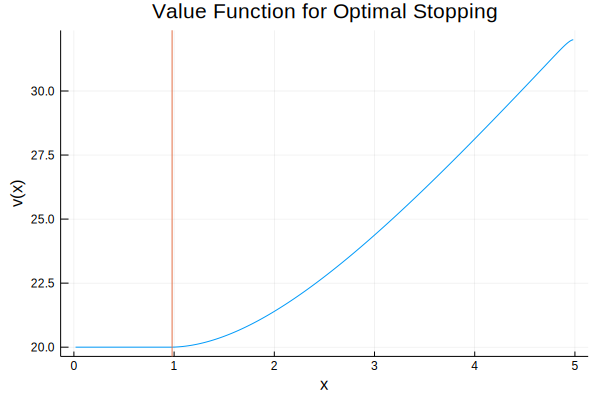

In [6]:
lb = zeros(M)
ub = 300*ones(M) # Need to have upper bounds for the z.
code, z, w_val = @suppress solveLCP(w, lb, ub)  # Solves (12)
@assert code == :Solved  # otherwise, an error in convergence

v = z + S.(x)  # (8)
x̂_index = findfirst(z .> 0)  # i.e. find first x index where non-binding
if isnothing(x̂_index)
  x̂ = Inf # i.e. never non-binding = always stop
else
  x̂ = x[x̂_index]
end

# plot the solution and the stopping threshold
plot(x, v, title = "Value Function for Optimal Stopping",
     legend = false, ylabel = "v(x)", xlabel = "x")
vline!([x̂])

**Performance Note** As always in Julia, only test performance of code within functions (i.e. the global variables here are only for simplicity)

### References
* [Github Source](https://github.com/QuantEcon/SimpleDifferentialOperators.jl/blob/master/docs/examples/LCP_jump_diffusion.jmd)
* [Huang, J. and J.-S. Pang (1998): "Option Pricing and Linear Complementarity,"](https://ecommons.cornell.edu/handle/1813/5453)
* [Ben Moll's notes](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf)